# Introduction
## What we are trying to accomplish
In general we are trying to provide answers to the following questions:
- How is the adoption of renewable energy in Europe evolving?
- How is the adoption of different types of renewable energy evolving?
- Are there characteristics of countries that correlate with their level of adoption of renewable energy?

### Main Questions
As these questions are defined very broadly and can be answered in a variety of ways, we decided to formulate the following more discreet questions, focusing on the production and consumption of renewable energy in europe:
- How has the adoption of renewable energy in Europe developed over time?
- Which types of renewable energy have been predominantly adopted?

### Sub Questions
- How do economic factors like GDP and electricity prices influence the adoption of renewable energy?
- How does austria compare to the european average?

## Data Description
We are using the dataset from [Kaggle](https://www.kaggle.com/datasets/programmerrdai/renewable-energy/data). The general description can be found at the original [ourworldindata.org](https://ourworldindata.org/grapher/installed-solar-pv-capacity#:~:text=IRENA%20%E2%80%93%20Renewable%20Capacity-,Statistics) data source.
**Absolute Values:** Absolute measurements are represented in megawatts (MW) rounded to the nearest one megawatt, with figures between zero and 0.5MW shown as a 0.
**Shares:** Shares are represented as percentages

## Reading the data
### Main data sources
Load all required packages and modules

In [ ]:
import glob
import os
import pickle
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

The dataset contains a wide range of data from different countries and time ranges. In this exercise we chose to only consider **european** countries and compare them to the overall european and global trends. We take the **years (1990-2020)** into consideration to answer our questions.

In [ ]:
# ISO codes for European countries
country_codes_main_data = (
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA',
    'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT',
    'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'GBR')
entities = ('Europe', 'World')
time_window = (1980, 2020)

We clean the data by:
- Removing all non-European countries
- Only consider our targeted time window (1990-2020)

In [ ]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    # Only Use European Countries & Europe/World accumulated data
    df = df[(df['Code'].isin(country_codes_main_data)) | (df['Entity'].isin(entities))]

    if 'Year' in df.columns:
        df.loc[:, 'Year'] = pd.to_numeric(df['Year'], errors='coerce')
        df = df[(df['Year'] >= time_window[0]) & (df['Year'] <= time_window[1])]


    # Remove 'Code' Column, as it is redundant
    df.drop(columns=['Code'], inplace=True)

    df.reset_index(drop=True, inplace=True)

    return df

Put it all together and read and clean the dataframes:

In [ ]:
def read_and_clean_csv(file) -> pd.DataFrame:
    df = pd.read_csv(file)
    df = clean_df(df)
    return df

folder_path_main_data = os.path.join('..', 'data')
csv_files = glob.glob(os.path.join(folder_path_main_data, '*.csv'))

dataframes = {os.path.basename(file).split('.')[0]: read_and_clean_csv(file) for file in csv_files}

#### Merge semantically relevant dataframes
Now we merge dataframes that contain semantically relevant data into one. These are:
- `share_energy:` merged from `hydro-share-energy`,`solar-share-energy`,`wind-share-energy`,`renewable-share-energy`
- `share_electricity:` merged from `share-electricity-hydro`,`share-electricity-solar`,`share-electricity-solar`,`share-electricity-wind`,`share-electricity-renewables`
- `energy_consumption_electricity_production:` merged from `modern-renewable-prod`, `modern-renewable-energy-consumption`



In [ ]:
def merge_share_dfs(dfs: dict[str: pd.DataFrame], sub_str: str) -> pd.DataFrame:
    relevant_keys = [key for key in dfs.keys() if sub_str in key]
    filtered_dfs = dfs[relevant_keys[0]]
    for key in relevant_keys[1:]:
        filtered_dfs = filtered_dfs.merge(
            dfs[key],
            on=['Entity', 'Year'],
            how='outer'
        )
    return filtered_dfs

def merge_production_consumption(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df1, df2,
                  on=['Entity', 'Year'],
                  how='outer'
                  )
    return df

Let's start off by merging the overall share percentages.

In [ ]:
share_energy_long = merge_share_dfs(dataframes, 'share-energy')
share_electricity_long = merge_share_dfs(dataframes, 'share-electricity')
installed_capacity_long = merge_share_dfs(dataframes, 'capacity')

Add new columns based on already existing data.

In [ ]:
share_energy_long['Other Renewables (% sub energy)'] = share_energy_long['Renewables (% sub energy)'] - ((share_energy_long['Solar (% sub energy)']) + (share_energy_long['Hydro (% sub energy)']) + (share_energy_long['Wind (% sub energy)']))
share_electricity_long['Other Renewables (% electricity)'] = share_electricity_long['Renewables (% electricity)'] - ((share_electricity_long['Solar (% electricity)']) + (share_electricity_long['Hydro (% electricity)']) + (share_electricity_long['Wind (% electricity)']))

installed_capacity_long['Total Capacity'] = installed_capacity_long['Wind Capacity'].fillna(0) + installed_capacity_long['Geothermal Capacity'].fillna(0) + installed_capacity_long['Solar Capacity'].fillna(0)

Now let's finish by merging the absolute values for production/consumption.

In [ ]:
electricity_production_long = dataframes['modern-renewable-prod']
electricity_production_long = electricity_production_long.rename(columns=
                                                       {
                                                           'Electricity from wind (TWh)': 'Electricity production wind (TWh)',
                                                           'Electricity from hydro (TWh)': 'Electricity production hydro (TWh)',
                                                           'Electricity from solar (TWh)': 'Electricity production solar (TWh)',
                                                           'Electricity from other renewables including bioenergy (TWh)': 'Electricity production other renewables including bioenergy (TWh)'
                                                        })

energy_consumption_long = dataframes['modern-renewable-energy-consumption']
energy_consumption_long = energy_consumption_long.rename(columns=
                                                       {
                                                           'Wind Generation - TWh': 'Wind consumption (TWh)',
                                                           'Solar Generation - TWh': 'Solar consumption (TWh)',
                                                           'Geo Biomass Other - TWh': 'Other renewable consumption (TWh)',
                                                           'Hydro Generation - TWh': 'Hydro consumption (TWh)',
                                                        })

energy_consumption_electricity_production_long = merge_production_consumption(energy_consumption_long, electricity_production_long)

#### Multi-Index
These newly merged frames can now be converted from a long format to a wide multi-index dataformat. We have decided to multi-index all source our dataframes on `Entity`,`Year`

In [ ]:
share_energy = share_energy_long.set_index(['Entity', 'Year'])
share_electricity = share_electricity_long.set_index(['Entity','Year'])
installed_capacity = installed_capacity_long.set_index(['Entity', 'Year'])
energy_consumption_electricity_production = energy_consumption_electricity_production_long.set_index(['Entity', 'Year'])

### Secondary Data Sources
In order to make reasonable assumptions, we include some additional external data sources for:
- GDP per capita (USD)
- Electricity Prices (EUR/kWh)



In [ ]:
folder_path_secondary_data = os.path.join('..', 'secondary-data')

Let's start with the GDP per capita.

In [ ]:
def melt_gdp_year_columns(df: pd.DataFrame) -> pd.DataFrame:
    df_melted = df.melt(
        id_vars=["Entity", "Code"],  # Keep these columns as they are
        var_name="Year",                   # New column name for years
        value_name="GDP per capita (USD)"                 # New column name for values
    )

    # Convert the 'Year' column to numeric, ignoring non-numeric entries
    df_melted["Year"] = pd.to_numeric(df_melted["Year"], errors="coerce")

    # Drop rows where 'Year' or 'Value' is NaN
    df_melted = df_melted.dropna(subset=["Year", "GDP per capita (USD)"]).reset_index(drop=True)

    df_melted["Year"] = df_melted["Year"].astype(int)

    return df_melted

In [ ]:
# GDP per capita (USD)
gdp_per_capita_csv_file = os.path.join(folder_path_secondary_data, 'gdp_per_capita.csv')
gdp_per_capita_original = pd.read_csv(gdp_per_capita_csv_file)
gdp_per_capita_long = melt_gdp_year_columns(gdp_per_capita_original)
gdp_per_capita_long = clean_df(gdp_per_capita_long)

Now we take a look at the electricity prices. Because this is an external dataset, we cannot simply use the same time frame we have set for our primary data. This dataset only contains values from 2007 onward.

In [ ]:
country_code_to_name_electricity_price_data = {
    'AT': 'Austria', 'BE': 'Belgium', 'BG': 'Bulgaria', 'HR': 'Croatia',
    'CY': 'Cyprus', 'CZ': 'Czechia', 'DK': 'Denmark', 'EE': 'Estonia',
    'FI': 'Finland', 'FR': 'France', 'DE': 'Germany', 'EL': 'Greece',
    'HU': 'Hungary', 'IS': 'Iceland', 'IE': 'Ireland', 'IT': 'Italy',
    'LV': 'Latvia', 'LT': 'Lithuania', 'LU': 'Luxembourg', 'NL': 'Netherlands',
    'NO': 'Norway', 'PL': 'Poland', 'PT': 'Portugal', 'RO': 'Romania',
    'SK': 'Slovakia', 'SI': 'Slovenia', 'ES': 'Spain', 'SE': 'Sweden',
    'CH': 'Switzerland', 'UK': 'United Kingdom'
}

# TODO check if we should just cut off at year 2020
time_window_electricity_price = (2007, 2025)

# Filter for the selected countries
selected_country_codes = set(country_code_to_name_electricity_price_data.keys())

In [ ]:
def clean_numeric_values(val):
    """
    Function ensures numeric conversion for time columns
    :param val:
    :return:
    """
    if isinstance(val, str):
        return re.sub(r'[^\d.-]', '', val.strip())  # Remove non-numeric characters and strip spaces
    return val

def clean_electricity_price_df(df: pd.DataFrame) -> pd.DataFrame:
    # Strip whitespace from column names
    df.columns = [col.strip() for col in df.columns]

    # Extract the first column name dynamically
    first_column_name = df.columns[0]

    # Extract the country code from the first column
    df['Entity'] = df[first_column_name].str.split(',').str[-1].str.strip()
    df.drop(columns=[first_column_name], inplace=True)

    # Identify time-based columns (e.g., 2007-S1)
    time_columns = [col for col in df.columns if re.match(r'\d{4}-S\d', col)]

    # Clean time columns and convert to numeric
    #df[time_columns] = df[time_columns].applymap(clean_numeric_values).apply(pd.to_numeric, errors='coerce')
    # Assuming time_columns is a list of columns to clean
    df[time_columns] = df[time_columns].apply(lambda col: col.map(clean_numeric_values).apply(pd.to_numeric, errors='coerce'))


    # Deduplicate by country code
    df = df.drop_duplicates(subset=['Entity'])

    filtered_data = df[df['Entity'].isin(selected_country_codes)]

    return filtered_data

def convert_electricity_price_to_annual_means(df: pd.DataFrame) -> pd.DataFrame:
    # Calculate annual means (average of S1-S4 per year)
    annual_means = {}
    for year in range(time_window_electricity_price[0], time_window_electricity_price[1]):
        semesters = [f"{year}-S{semester}" for semester in range(1, 5)]
        available_semesters = [sem for sem in semesters if sem in df.columns]
        if available_semesters:
            annual_means[year] = df[available_semesters].mean(axis=1, skipna=True)

    # Create a DataFrame for annual means
    annual_means_df = pd.DataFrame(annual_means)
    annual_means_df.index = df['Entity']

    return annual_means_df

def read_clean_convert_electricity_prices(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, sep='\t')
    df = clean_electricity_price_df(df)
    df = convert_electricity_price_to_annual_means(df)
    return df


In [ ]:
household_electricity_csv_file = os.path.join(folder_path_secondary_data, 'estat_nrg_pc_204.tsv')
non_household_electricity_csv_file = os.path.join(folder_path_secondary_data, 'estat_nrg_pc_205.tsv')

household_electricity = read_clean_convert_electricity_prices(household_electricity_csv_file)
non_household_electricity = read_clean_convert_electricity_prices(non_household_electricity_csv_file)

# Align both DataFrames by their indices (countries) and columns (years)
combined_weather_and_power_data = (household_electricity + non_household_electricity) / 2

# Map country codes to their full names for better visualization
combined_weather_and_power_data.index = combined_weather_and_power_data.index.map(
    {k: v for k, v in country_code_to_name_electricity_price_data.items()}
)

In [ ]:
def melt_electricity_price_year_column(df: pd.DataFrame) -> pd.DataFrame:
    df_melted = df.reset_index()
    df_melted = df_melted.melt(
        id_vars=["Entity"],  # Keep these columns as they are
        var_name="Year",                   # New column name for years
        value_name="electricity price per kWh"                 # New column name for values
    )

    # Convert the 'Year' column to numeric, ignoring non-numeric entries
    df_melted["Year"] = pd.to_numeric(df_melted["Year"], errors="coerce")

    # Drop rows where 'Year' or 'Value' is NaN
    df_melted = df_melted.dropna(subset=["Year", "electricity price per kWh"]).reset_index(drop=True)

    df_melted["Year"] = df_melted["Year"].astype(int)

    return df_melted

In [ ]:
electricity_price_data_long = melt_electricity_price_year_column(combined_weather_and_power_data)

#### Multi-Index

In [ ]:
gdp_per_capita = gdp_per_capita_long.set_index(['Entity', 'Year']).sort_index()
electricity_price_data = electricity_price_data_long.set_index(['Entity', 'Year']).sort_index()

## Exploring the data
### Noticing Trends
Now let's create some plots in order to better observe certain trends

In [ ]:
data_filtered = share_energy.loc[:]

# Reset index to make Year a column for plotting
data_filtered = data_filtered.reset_index()

# Define standout countries
standout_countries = ['Austria', 'Europe', 'World']

# Create a custom color palette
palette = {country: 'black' for country in data_filtered['Entity'].unique()}
palette.update({
    'Austria': 'red',
    'Europe': 'blue',
    'World': 'green'
})

# Plot
plt.figure(figsize=(20, 10))

# Plot all countries with lighter lines
sns.lineplot(
    data=data_filtered[~data_filtered['Entity'].isin(standout_countries)],
    x='Year', y='Renewables (% sub energy)',
    hue='Entity', palette=palette, alpha=0.4, linewidth=1
)

# Plot standout countries with distinctive styles
sns.lineplot(
    data=data_filtered[data_filtered['Entity'].isin(standout_countries)],
    x='Year', y='Renewables (% sub energy)',
    hue='Entity', palette=palette, linewidth=2.5
)

# Add titles and labels
plt.title('Renewable Energy Usage Over Time', fontsize=18)
plt.ylabel('% of Energy from Renewables', fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.legend(title='Country', fontsize=12, title_fontsize=14)
plt.grid(True)

# Highlight lines with direct annotations
for country in standout_countries:
    country_data = data_filtered[data_filtered['Entity'] == country]
    plt.text(
        country_data['Year'].iloc[-1],
        country_data['Renewables (% sub energy)'].iloc[-1],
        country,
        color=palette[country], fontsize=12, weight='bold'
    )

plt.show()

In [ ]:
# Select data for Austria
country_austria = 'Austria'
data_austria = share_energy.loc[country_austria].reset_index()

# Select data for Europe
country_europe = 'Europe'
data_europe = share_energy.loc[country_europe].reset_index()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Plot for Austria
axes[0].stackplot(
    data_austria['Year'],
    data_austria['Hydro (% sub energy)'],
    data_austria['Solar (% sub energy)'],
    data_austria['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
axes[0].set_title(f'Renewable Energy Sources Contribution Over Time - {country_austria}', fontsize=14)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('% of Energy', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Plot for Europe
axes[1].stackplot(
    data_europe['Year'],
    data_europe['Hydro (% sub energy)'],
    data_europe['Solar (% sub energy)'],
    data_europe['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
axes[1].set_title(f'Renewable Energy Sources Contribution Over Time - {country_europe}', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].grid(True)

# Adjust layout
plt.suptitle('Comparison of Renewable Energy Sources: Austria vs Europe', fontsize=16)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

Even though we only have specific data for Hydro, Solar and Wing generation, there other renewable ways of generating energy. To show how much data we are missing on other renewable energy types, we plotted the most recent (2020) energy usage.

In [ ]:
# Filter the data for the year 2020
data_2020 = share_energy.xs(key=2020, level='Year')

# Sort by total renewables for better visualization
data_2020 = data_2020.sort_values(by='Renewables (% sub energy)', ascending=False)

# Create a stacked bar plot
plt.figure(figsize=(14, 10))

# Plot the total renewable energy as a separate bar beforehand
# This makes it show up as the other types of renewable energy that we are missing (e.g. not in hydro, wind, solar)
plt.barh(data_2020.index.get_level_values('Entity'), data_2020['Renewables (% sub energy)'], label='Other Renewables', color='gray', alpha=0.5)

# Plot the stacked bars for Hydro, Solar, and Wind
plt.barh(data_2020.index.get_level_values('Entity'), data_2020['Hydro (% sub energy)'], label='Hydro', color='blue')
plt.barh(
    data_2020.index.get_level_values('Entity'),
    data_2020['Solar (% sub energy)'],
    left=data_2020['Hydro (% sub energy)'],
    label='Solar',
    color='orange'
)
plt.barh(
    data_2020.index.get_level_values('Entity'),
    data_2020['Wind (% sub energy)'],
    left=data_2020['Hydro (% sub energy)'] + data_2020['Solar (% sub energy)'],
    label='Wind',
    color='green'
)

# Add labels and title
plt.title('Overview of Renewable Energy Usage by Country in 2020', fontsize=16)
plt.xlabel('% of Total Energy', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(title='Energy Source', fontsize=12, title_fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

### Which types of renewable energy have been predominantly adopted?
Plot how the percentage of renewable energy from different sources (Hydro, Solar, Wind, and Other Renewables) has changed globally, to get an overall view.

In [ ]:
# Filter for global data (use 'World' as the entity)
share_energy_europe = share_energy.xs(key='Europe', level='Entity')

# TODO replace with seaborn
# Plot trends in renewable energy types (Hydro, Solar, Wind, Other Renewables) globally
plt.figure(figsize=(14, 8))
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Hydro (% sub energy)'], label='Hydro', color='blue')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Solar (% sub energy)'], label='Solar', color='orange')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Wind (% sub energy)'], label='Wind', color='green')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Other Renewables (% sub energy)'], label='Other Renewables', color='purple')

plt.title('European Trends in Renewable Energy Adoption (1990-2020)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('% of Total Energy', fontsize=12)
plt.legend(title='Energy Type', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Do Countries keep their renewable energy mix?
Another interesting analysis is to see which year had the highest adoption of each energy source.

In [ ]:
# Find the year of highest adoption for each country and renewable energy type
standout_countries = ['Austria', 'Romania', 'Europe', 'World']
share_energy_standout_entities = share_energy.loc[standout_countries]
max_adoption_years = (
    share_energy_standout_entities.reset_index()  # Reset index to make 'Entity' and 'Year' columns
    .melt(
        id_vars=["Entity", "Year"],
        var_name="Renewable Energy Type",
        value_name="Adoption (%)"
    )  # Reshape to long format for easier grouping
    .groupby(["Entity", "Renewable Energy Type"], as_index=False, group_keys=False)  # Prevent adding group keys to the output
    .apply(lambda group: group.loc[group["Adoption (%)"].idxmax()])  # Find the row with max adoption
    .reset_index(drop=True)  # Clean up index
    .drop("Adoption (%)", axis=1)  # Optionally drop the value column if not needed
)

# Rename columns for clarity
max_adoption_years.columns = ["Country", "Renewable Energy Type", "Year"]

# Display the result
display(max_adoption_years)

Interestingly enough, even though general adoption of renewable energy is trending upwards, not all sources of renewable energy are crated equal. For example hydro power seems to have fallen out of fashion, with austria having the highest hydro share approximately 37 years ago.

This is most-likely the case, because hydro-power is hard to scale and reaches its maximum capacity for a given region very quickly.

### Do countries prefer wind or solar?
As we have just concluded that hydro-power is hard to scale, it would be interesting to know if most countries are opting for a wind or solar solution instead. This knowledge can be acquired by comparing the total wind/solar capacity via a scatter plot.

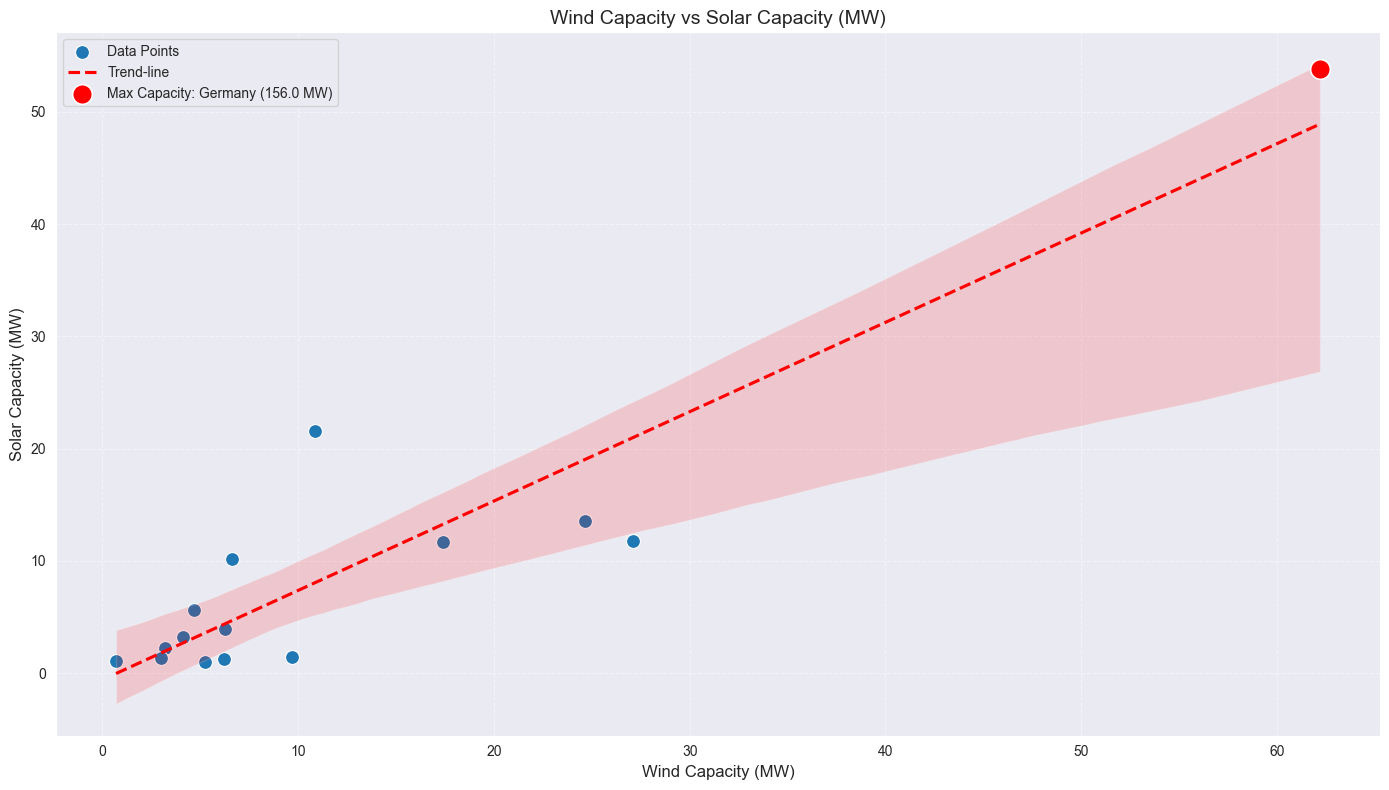

In [496]:
installed_capacity_2020 = installed_capacity.xs(key=2020, level='Year')
# Exclude non-country entities:
installed_capacity_2020_countries_only = installed_capacity_2020[~installed_capacity_2020.index.get_level_values("Entity").isin(["World", "Europe"])].copy()
installed_capacity_2020_countries_only["Solar+Wind Capacity"] = (
    installed_capacity_2020_countries_only["Wind Capacity"].fillna(0) +
    installed_capacity_2020_countries_only["Solar Capacity"].fillna(0)
)

# Identify the entity with the maximum total capacity
max_entity = installed_capacity_2020_countries_only["Solar+Wind Capacity"].idxmax()
max_capacity = installed_capacity_2020_countries_only.loc[max_entity]

installed_capacity_2020_countries_only_reset = installed_capacity_2020_countries_only.reset_index()

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=installed_capacity_2020_countries_only_reset,
    x="Wind Capacity",
    y="Solar Capacity",
    s=100,
    label="Data Points",
)

sns.regplot(
    data=installed_capacity_2020_countries_only_reset,
    x="Wind Capacity",
    y="Solar Capacity",
    scatter=False,
    color="red",
    label="Trend-line",
    line_kws={"linestyle": "--"},
)

# Highlight the point with the highest capacity
sns.scatterplot(
    x=[max_capacity["Wind Capacity"]],
    y=[max_capacity["Solar Capacity"]],
    color="red",
    s=200,
    label=f"Max Capacity: {max_entity} ({max_capacity['Total Capacity']:.1f} MW)",
)

plt.title("Wind Capacity vs Solar Capacity (MW)", fontsize=14)
plt.xlabel("Wind Capacity (MW)", fontsize=12)
plt.ylabel("Solar Capacity (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

The trend line indicates, that solar and wind capacity seems to grow together. No country is only leaning heavily into just wind or solar.

# Interesting statistics and relations
Merge the share percentages into a single frame for easier plotting and data analysis


In [ ]:
share_energy_electricity = pd.merge(
    share_energy,
    share_electricity,
    left_index=True,
    right_index=True,
    how='inner'
)

Additionally merge all our data into a single **mega-frame** for easier plotting/training

In [ ]:
def construct_mega_frame(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    mega_df = dfs[0]

    for df in dfs[1:]:
        mega_df = pd.merge(
            mega_df,
            df,
            left_index=True,
            right_index=True,
            how='outer'
        )

    return mega_df

In [ ]:
dfs = [share_energy_electricity, installed_capacity, gdp_per_capita, energy_consumption_electricity_production, electricity_price_data]
mega_df = construct_mega_frame(dfs)
display(mega_df)

## Relation between energy and electricity
### Visualizations
First we look at the energy-electricity gap. Let's plot the countries with the largest gap.
**Gap:** The difference between energy and electricity adoption

In [ ]:
# Filter for the year 2020
data_2020 = share_energy_electricity.xs(key=2020, level='Year').copy()  # Use `.copy()` to avoid the warning

# Calculate the gap between Renewable Electricity and Renewable Energy
data_2020.loc[:, 'Gap'] = data_2020['Renewables (% electricity)'] - data_2020['Renewables (% sub energy)']

# Sort by the largest gap
largest_gaps = data_2020[['Gap']].sort_values(by='Gap', ascending=False).reset_index()

# Bar plot for the largest gaps in 2020
plt.figure(figsize=(12, 6))
sns.barplot(data=largest_gaps.head(10), x='Gap', y='Entity', palette='coolwarm', hue='Entity', dodge=False, legend=False)
plt.title('Top 10 Countries with Largest Gaps (Renewables: Electricity vs Energy) - 2020', fontsize=16)
plt.xlabel('Gap (% Electricity - % Energy)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Let's compare Austria to the rest of europe.

In [ ]:
# Filter for the last 10 years (2011–2020)
energy_electricity_long = share_energy_electricity.copy()

# Calculate the gap for each country and year
energy_electricity_long.loc[:, 'Gap'] = energy_electricity_long['Renewables (% electricity)'] - energy_electricity_long['Renewables (% sub energy)']

# Reset index for plotting
gap_over_time = energy_electricity_long.reset_index()

# Define standout countries
standout_countries = ['Austria', 'Europe', 'World']

# Create a custom color palette
palette = {country: 'gray' for country in gap_over_time['Entity'].unique()}
palette.update({
    'Austria': 'red',
    'Europe': 'blue',
    'World': 'green'
})

plt.figure(figsize=(14, 8))

# Plot all countries with lighter lines
sns.lineplot(
    data=gap_over_time[~gap_over_time['Entity'].isin(standout_countries)],
    x='Year', y='Gap', hue='Entity', palette=palette, alpha=0.4, linewidth=1, legend=False
)

# Plot standout countries with distinctive styles
sns.lineplot(
    data=gap_over_time[gap_over_time['Entity'].isin(standout_countries)],
    x='Year', y='Gap', hue='Entity', palette=palette, linewidth=2.5
)

# Add labels and title
plt.title(f'Renewable Electricity vs Energy Gap ({time_window[0]}-{time_window[1]})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Gap (% Electricity - % Energy)', fontsize=12)
plt.legend(title='Country', fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)

# Highlight standout countries with direct annotations
for country in standout_countries:
    country_data = gap_over_time[gap_over_time['Entity'] == country]
    plt.text(
        country_data['Year'].iloc[-1],
        country_data['Gap'].iloc[-1],
        country,
        color=palette[country], fontsize=12, weight='bold'
    )

plt.tight_layout()
plt.show()


In [ ]:
# Define europe_world (if not already defined)
europe_world = share_energy_electricity.loc[
    share_energy_electricity.index.get_level_values('Entity').isin(['Europe', 'World'])
].reset_index()

europe_world.rename(columns={'Entity': 'Country'}, inplace=True)

# Reshape the data to combine 'Renewables (% sub energy)' and 'Renewables (% electricity)' into one column
europe_world_melted = europe_world.melt(
    id_vars=['Year', 'Country'],
    value_vars=['Renewables (% sub energy)', 'Renewables (% electricity)'],
    var_name='Renewable Metric',
    value_name='Percentage'
)

# Rename metrics for better readability
europe_world_melted['Renewable Metric'] = europe_world_melted['Renewable Metric'].replace({
    'Renewables (% sub energy)': '% Sub Energy',
    'Renewables (% electricity)': '% Electricity'
})

# Create a line plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=europe_world_melted,
    x='Year',
    y='Percentage',
    hue='Country',
    style='Renewable Metric',  # Different styles for sub energy vs electricity
    markers=True,
    dashes=True,
    palette='tab10'
)

# Add plot titles and labels
plt.title('Renewable Energy and Electricity Trends (Europe & World)', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

# Customize the legend for clarity
plt.legend(title='Legend', fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add grid and show plot
plt.grid(True)
plt.tight_layout()
plt.show()

## Dependency on weather data
Let's check how depended the renewable energy types are on certain weather data. For this we fetch daily solar radiation and wind speed data for European countries from the NASA POWER API, covering the years 2010 to 2020. It processes this data to calculate yearly averages for each country.

The result is a consolidated dataset linking weather conditions with renewable energy adoption. This data will be used for analyzing the relationship between weather and renewable energy adoption in Europe.

In [ ]:
import requests

# List of European countries
european_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
    'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
    'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands',
    'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
    'Sweden', 'Switzerland', 'United Kingdom'
]

# Function to fetch weather data
def fetch_weather_data(lat, lon, start_year, end_year):
    """Fetch daily solar radiation and wind speed data from NASA POWER API."""
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "ALLSKY_SFC_SW_DWN,WS10M",
        "community": "AG",
        "longitude": lon,
        "latitude": lat,
        "start": f"{start_year}0101",
        "end": f"{end_year}1231",
        "format": "JSON",
        "header": "true",
        "time-standard": "UTC"
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.json()

# Dictionary of country coordinates (add exact latitude and longitude for each country)
country_coordinates = {
    'Austria': (47.5162, 14.5501),
    'Belgium': (50.8503, 4.3517),
    'Bulgaria': (42.7339, 25.4858),
    'Croatia': (45.1, 15.2),
    'Cyprus': (35.1264, 33.4299),
    'Czechia': (49.8175, 15.473),
    'Denmark': (56.2639, 9.5018),
    'Estonia': (58.5953, 25.0136),
    'Finland': (61.9241, 25.7482),
    'France': (46.6034, 1.8883),
    'Germany': (51.1657, 10.4515),
    'Greece': (39.0742, 21.8243),
    'Hungary': (47.1625, 19.5033),
    'Iceland': (64.9631, -19.0208),
    'Ireland': (53.4129, -8.2439),
    'Italy': (41.8719, 12.5674),
    'Latvia': (56.8796, 24.6032),
    'Lithuania': (55.1694, 23.8813),
    'Luxembourg': (49.8153, 6.1296),
    'Malta': (35.9375, 14.3754),
    'Netherlands': (52.1326, 5.2913),
    'Norway': (60.4720, 8.4689),
    'Poland': (51.9194, 19.1451),
    'Portugal': (39.3999, -8.2245),
    'Romania': (45.9432, 24.9668),
    'Slovakia': (48.6690, 19.6990),
    'Slovenia': (46.1512, 14.9955),
    'Spain': (40.4637, -3.7492),
    'Sweden': (60.1282, 18.6435),
    'Switzerland': (46.8182, 8.2275),
    'United Kingdom': (55.3781, -3.4360)
}

# Fetch weather data for each country
time_window_weather = (2010, 2020)
weather_data = {}

file_path ='api_data.pkl'
cached_api_data = {}
if os.path.exists(file_path):
    with open(file_path, 'rb') as file:  # Use "rb" mode to read in binary format
        cached_api_data = pickle.load(file)

for country, (lat, lon) in country_coordinates.items():
    print(f"Fetching weather data for {country}...")
    try:
        key = (lat, lon)
        if key not in cached_api_data:
            cached_api_data[key] = fetch_weather_data(key[0], key[1], time_window_weather[0], time_window_weather[1])

        data = cached_api_data[key]
        daily_data = data['properties']['parameter']
        df = pd.DataFrame({
            'Date': pd.to_datetime(list(daily_data['ALLSKY_SFC_SW_DWN'].keys())),
            'Solar Radiation': list(daily_data['ALLSKY_SFC_SW_DWN'].values()),
            'Wind Speed': list(daily_data['WS10M'].values())
        })
        df['Year'] = df['Date'].dt.year
        yearly_data = df.groupby('Year')[['Solar Radiation', 'Wind Speed']].mean().reset_index()
        weather_data[country] = yearly_data
    except Exception as e:
        print(f"Failed to fetch weather data for {country}: {e}")

# save cached weather data
with open(file_path, 'wb') as file:
    pickle.dump(cached_api_data, file)

# Extract power data from `share_energy`
power_data = pd.DataFrame()
for country in european_countries:
    if country in share_energy.index.get_level_values('Entity'):
        country_power_data = share_energy.loc[country].reset_index()
        country_power_data['Country'] = country
        power_data = pd.concat([power_data, country_power_data])

# Combine weather and power data
combined_weather_and_power_data = pd.DataFrame()
for country, weather_df in weather_data.items():
    power_df = power_data[power_data['Country'] == country]
    combined = weather_df.merge(power_df, on='Year', how='inner')
    combined['Country'] = country
    combined_weather_and_power_data = pd.concat([combined_weather_and_power_data, combined])

### Relation of Wind Speed to Wind energy adoption
Let's visualize the relationship between wind speed and wind energy adoption (percentage of energy from wind) across European countries.

In [ ]:
combined_weather_and_power_data_reset = combined_weather_and_power_data.reset_index()

# Create the scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=combined_weather_and_power_data_reset,
    x="Wind Speed",
    y="Wind (% sub energy)",
    hue="Country",  # Optional: Differentiate points by country
    alpha=0.8  # Transparency for better visibility of overlapping points
)

# Add the trend line (regression line)
sns.regplot(
    data=combined_weather_and_power_data_reset,
    x="Wind Speed",
    y="Wind (% sub energy)",
    scatter=False,  # Don't plot the points again
    color="red",    # Color of the trend line
    line_kws={"linestyle": "--"},  # Make the line dashed
)

# Add labels and title
plt.title("Wind Speed vs Wind (% of Energy)", fontsize=16)
plt.xlabel("Wind Speed", fontsize=12)
plt.ylabel("Wind (% of Energy)", fontsize=12)
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend placement
plt.tight_layout()

# Show the plot
plt.show()

### Relation of Solar radiation to Solar energy adoption
Let's visualize the relationship between solar radiation and solar energy adoption (percentage of energy from wind) across European countries.

In [ ]:
# Create the scatter plot
plt.figure(figsize=(14, 8))
scatter_plot = sns.scatterplot(
    data=combined_weather_and_power_data_reset,
    x="Solar Radiation",
    y="Solar (% sub energy)",
    hue="Country",  # Optional: Differentiate points by country
    alpha=0.8  # Transparency for better visibility of overlapping points
)

# Add the trend line (regression line)
sns.regplot(
    data=combined_weather_and_power_data_reset,
    x="Solar Radiation",
    y="Solar (% sub energy)",
    scatter=False,  # Don't plot the points again
    color="red",    # Color of the trend line
    line_kws={"linestyle": "--"},  # Make the line dashed
)

# Add labels and title
plt.title("Solar Radiation vs Solar (% of Energy)", fontsize=16)
plt.xlabel("Solar Radiation", fontsize=12)
plt.ylabel("Solar (% of Energy)", fontsize=12)
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend placement
plt.tight_layout()

# Show the plot
plt.show()

Calculate European averages for each year

In [ ]:
european_averages = combined_weather_and_power_data.groupby('Year').agg({
    'Wind Speed': 'mean',
    'Wind (% sub energy)': 'mean',
    'Solar Radiation': 'mean',
    'Solar (% sub energy)': 'mean'
}).reset_index()

### Relation of wind speed and adoption for specific years
In order to get a better understanding for the wind dependency development of recent history, we plot the state in 2010,2015,2025.

In [ ]:
# Get all unique years and select specific years
all_years = combined_weather_and_power_data['Year'].unique()
specific_years = (all_years[0], all_years[len(all_years) // 2], all_years[-1])
combined_weather_and_power_data_specific_years = combined_weather_and_power_data[combined_weather_and_power_data['Year'].isin(specific_years)]

# Adjust the height and aspect ratio for better layout
g = sns.relplot(
    data=combined_weather_and_power_data_specific_years,
    x='Wind Speed',
    y='Wind (% sub energy)',
    col='Year',
    kind='scatter',
    col_wrap=3,  # Number of plots per row
    height=5,  # Height of each subplot
    aspect=1.5,  # Aspect ratio of each subplot
    alpha=0.6,
    hue='Country',
    palette='tab20',
    legend='brief'  # Automatic legend for countries
)

# Highlight Austria and add European averages with labels
for ax, year in zip(g.axes.flat, combined_weather_and_power_data_specific_years['Year'].unique()):
    # Highlight Austria
    austria_data = combined_weather_and_power_data_specific_years[
        (combined_weather_and_power_data_specific_years['Country'] == 'Austria') &
        (combined_weather_and_power_data_specific_years['Year'] == year)
    ]
    if not austria_data.empty:
        ax.scatter(
            austria_data['Wind Speed'], austria_data['Wind (% sub energy)'],
            color='red', s=150, edgecolor='black', zorder=5  # Highlight Austria
        )
        # Add label for Austria
        ax.text(
            austria_data['Wind Speed'].values[0] + 0.1,
            austria_data['Wind (% sub energy)'].values[0],
            'Austria', color='red', fontsize=8, weight='bold'
        )
    # Add European average
    avg_data = european_averages[european_averages['Year'] == year]
    if not avg_data.empty:
        ax.scatter(
            avg_data['Wind Speed'], avg_data['Wind (% sub energy)'],
            color='black', s=150, marker='x', zorder=6  # Highlight European average
        )
        # Add label for European average
        ax.text(
            avg_data['Wind Speed'].values[0] + 0.1,
            avg_data['Wind (% sub energy)'].values[0],
            'Europe Avg', color='black', fontsize=8, weight='bold'
        )

# Adjust layout and title to avoid overlap
g.fig.subplots_adjust(top=0.85)  # Adjust space for the title
g.fig.suptitle('Dependency Between Wind Speed and Wind (% sub energy) by Year', fontsize=16)
g.tight_layout()  # Automatically adjust layout to fit elements
plt.show()

## What other measures are correlated with the adoption of renewable energy/electricity?
Finally we want to look at the correlations between the renewable energy adoption and external variables, such as GDP, Electricity Prices. This is best done via a correlation matrix heatmap for some additional insight.

In [ ]:
mega_df_inner = mega_df.dropna()

columns_to_drop = [
    # Drop 100%
    'Hydro (% sub energy)',
    'Solar (% sub energy)',
    'Wind (% sub energy)',
    'Other Renewables (% sub energy)',
    'Hydro (% electricity)',
    'Solar (% electricity)',
    'Wind (% electricity)',
    'Other Renewables (% electricity)',
    'Wind consumption (TWh)',
    'Solar consumption (TWh)',
    'Other renewable consumption (TWh)',
    'Hydro consumption (TWh)',
    # Drop maybe
    'Electricity production hydro (TWh)',
    'Electricity production solar (TWh)',
    'Electricity production wind (TWh)',
    'Electricity production other renewables including bioenergy (TWh)'
]
mega_df_inner_filtered = mega_df_inner.drop(columns=columns_to_drop)

correlation_matrix = mega_df_inner_filtered.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Create a heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8}
)

# Add title
plt.title("Correlation Matrix: Renewable Energy Adoption and Other Measures", fontsize=14)

# Show the plot
plt.show()

The one thing we want to highlight in this plot is the low correlation between the adoption of renewable energy and GDP per capita. One would assume that richer european countries (with a higher GDP) would opt for more renewable energy, but alas this is not the case. They are actually inversely correlated.

Even though this is the case, there is still a strong correlation between Wind/Solar capacity and GDP per capita.

# Predictions for the future

In [ ]:
# TODO: Train a model and crate a graph for how the future could look like?

data_filtered = share_energy.reset_index()

X = data_filtered[['Year', 'Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']]
y = data_filtered['Renewables (% sub energy)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation RMSE: ", (-grid_search.best_score_) ** 0.5)

best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)

test_rmse = mean_squared_error(y_test, y_pred)
print(f"Test Set RMSE with Best Model: {test_rmse}")

## Predictions using random Random Forest

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

df = data_filtered.sort_values(by=['Year'])

X_columns = ['Year', 'Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']
scaler = StandardScaler()

rfr_model = grid_search.best_estimator_


plt.figure(figsize=(12, 8))

countries = ['Austria', 'Belgium', 'Czechia', 'Europe', 'France', 'Germany', 'Spain', 'Norway', 'Romania', 'United Kingdom', 'World']
colors = plt.cm.tab10(np.linspace(0, 1, len(countries)))

for i, country in enumerate(countries):
    country_df = df[df['Entity'] == country]
    if country_df.empty:
        print(f"Skipping country {country} due to no data available.")
        continue

    X = country_df[X_columns]
    y = country_df['Renewables (% sub energy)']

    X_scaled = scaler.fit_transform(X)

    rfr_model.fit(X_scaled, y)

    last_known_year = country_df['Year'].max()
    future_years = np.arange(last_known_year + 1, last_known_year + 31)

    future_data = []

    for feature in X_columns[1:]:
        lr = LinearRegression()
        lr.fit(country_df[['Year']], country_df[feature])

        future_years_df = pd.DataFrame(future_years, columns=['Year'])
        future_feature_values = lr.predict(future_years_df)
        future_data.append(future_feature_values.flatten())

    future_data = np.column_stack([future_years] + future_data)

    future_df = pd.DataFrame(future_data, columns=X_columns)
    future_data_scaled = scaler.transform(future_df)
    future_predictions = rfr_model.predict(future_data_scaled)

    line = plt.plot(country_df['Year'], y, label=f'Actual {country}', linewidth=2, color = colors[i])
    prediction = plt.plot(future_years, future_predictions, label=f'Predicted {country}', linestyle='--', color = colors[i])

plt.xlabel('Year')
plt.ylabel('Renewables (% sub energy)')
plt.title('Actual vs Predicted Renewables for Each Country (Next 50 Years)')
plt.legend()
plt.grid(True)
plt.show()

Here we predicted the development of renewable energy adoption until 2050. To do this, we used a simple model in order to interpolate the values of the different features such as previous Hydro, Wind or Solar adoption.